# Abstract

Using [medical data](https://www.kaggle.com/ronitf/heart-disease-uci), I predicted whether patients have a heart disease. At first, it was shown that K-fold mean-target encoding for categorical features and standardization of numerical features improve the prediction accuracy and logloss value for the test dataset when using LightGBM. In addition to the LightGBM, random forest model and neural network model were also trained to make a prediction. The predicted probabilities obtained from these 3 models were used to construct a new feature matrix and fed to a logistic regression model to make a final prediction. This ensemble learning technique, called stacking, improved the prediction accuracy of the heart disease.

# Importing Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import lightgbm as lgbm
from sklearn.metrics import log_loss
from tensorflow import set_random_seed
from keras import models, optimizers
from keras import layers
from keras import metrics
from keras import callbacks
from keras import regularizers
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from keras import backend as K
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.ticker as ticker


import warnings
warnings.filterwarnings("ignore")

# Data Preparation

The data used in this notebook is available in [Kaggle](https://www.kaggle.com/ronitf/heart-disease-uci) and stored in data.csv. At first, a dataframe is created using the pandas library.

In [3]:
df=pd.read_csv("../heart_desease/data.csv")
print("Dataframe shape",df.shape)
df.head()

Dataframe shape (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


There are 13 features.

- Age
- Sex: 0 or 1
- cp: chest pain type. There are 4 types, 0, 1, 2, and 3.
- trestbps: resting blood pressure
- chol: serum cholestoral in mg/dl 
- fbs: fasting blood sugar > 120 mg/dl. 0 or 1
- restecg: resting electrocardiographic results. 0, 1, 2
- exang: exercise induced angina (1 = yes; 0 = no)
- slope: the slope of the peak exercise ST segment. 0, 1, 2
- ca: number of major vessels (0-3) colored by fluoroscopy. 0, 1, 2, 3
- thal: 0, 1, 2, 3

The target takes a value of 0 or 1.

The column names are classified into categorical and numerical lists.

In [4]:
col_name = df.columns.tolist() # get column names
col_name.remove('target') # omit 'target'

numerical_col_label=['age', 'trestbps', 'chol', 'thalach','oldpeak']
binary_col_label = ['sex', 'fbs', 'exang']
categorical_col_label=['cp', 'restecg', 'slope', 'ca', 'thal']

The target value is defined as y. The rest of the other values is defined as X (feature matrix).

In [5]:
X=df[col_name].copy()
y=df['target'].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (303, 13)
y shape: (303,)


# Exploratory Data Analysis (EDA)

## Missing Values

As you can see in the next cell, there are no missing values in the present dataset.

In [6]:
print(X.isnull().sum()) # check the number of missing values in each column.

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


## Statistical Information of Continuous Variables

Let us get statistical information of continuous variables.

In [7]:
X[numerical_col_label].describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


The obtained statistical information can be visualized using box plots.

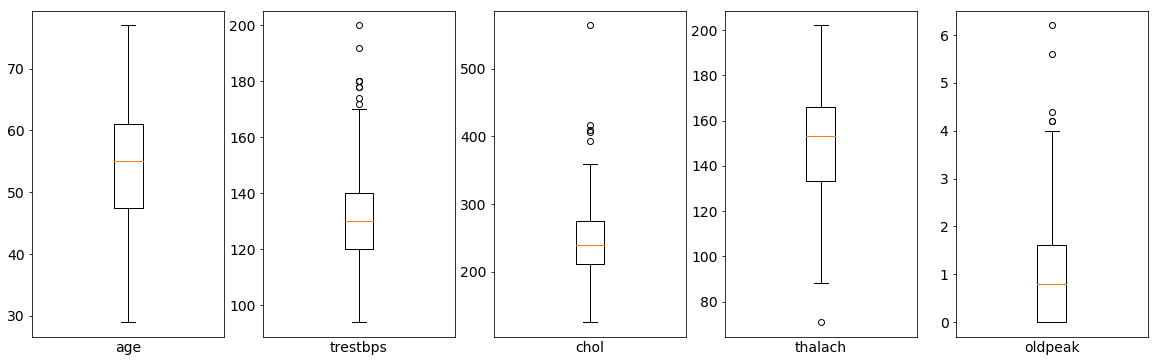

In [8]:
plt.figure(figsize=(20,6))
plt.rcParams.update({'font.size': 14})

for i, col_name in enumerate(numerical_col_label):
    plt.subplot(1,5,i+1)
    plt.boxplot(X[col_name], showfliers=True)
    plt.tick_params(bottom=False,left=True,labelbottom=False,labelleft=True)
    plt.xlabel(col_name)

plt.show()

The data of age does not have outliers. In contrast, other numerical data show outliers. You can also see skewness.

## Pairs plot
Here, a pairs plot for numerical data is presented.

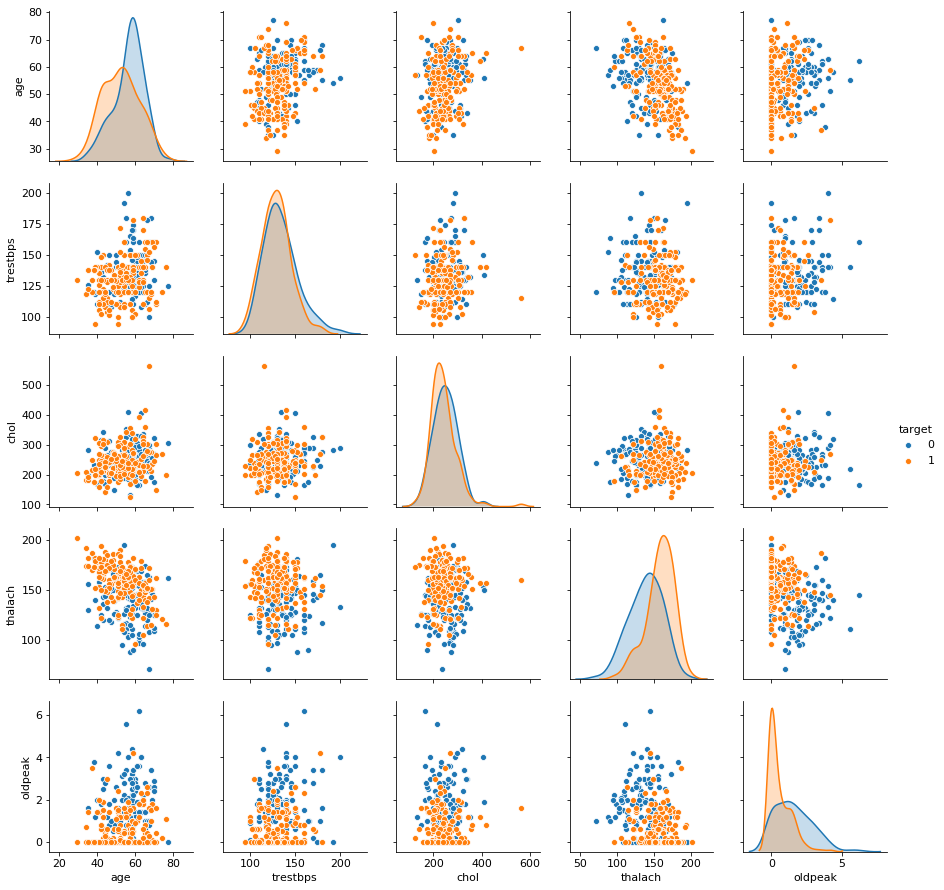

In [9]:
plt.rcParams.update({'font.size': 11})
sns.pairplot(X.join(y), hue='target', vars=numerical_col_label)
None

- The target 0 and 1 of the age, thalach, and oldpeak show different distributions. For instance, if the target value is 1, thalach tends to be high. 
- The feature "chol" has small numbers of outliers as we saw in the box plot. If you ignore the outliers, the distribution is relatively symmetric and does not show a large difference for the target 0 and 1.
- The distribution of the feature "trestbps has a tail, which means it is skewed. 

## Correlation

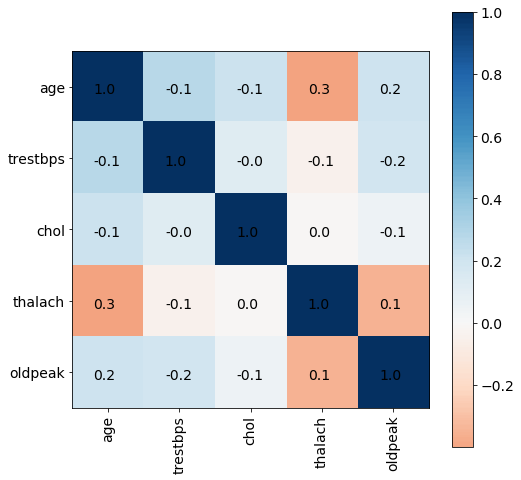

In [10]:
cor_method='pearson'

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,8))
plt.imshow(X[numerical_col_label].corr(method=cor_method).values,cmap='RdBu')
plt.colorbar().set_clim(vmin=-1, vmax=1)

for i in range(X[numerical_col_label].corr(method=cor_method).values.shape[0]):
    for j in range(X[numerical_col_label].corr(method=cor_method).values.shape[1]):
        plt.text(i-0.2,j+0.1,'%0.1f'%X.corr(method=cor_method).values[i,j])

plt.yticks([0,1,2,3,4],numerical_col_label)
plt.xticks([0,1,2,3,4],numerical_col_label,rotation='vertical')

plt.show()

As you can see, there are no strong correlations among the features. Therefore, all numerical features can be used when training models.

## Categorical Features

The target value can take the values of 0 or 1 based on whether a patient has a heart disease or not. The proportion of the target value is shown as a bar chart in the next cell. As you can see, their ratio is not so far from unity. Hence, it is not necessary to select data to adjust the ratio and is possible to use all of the provided data.

1    165
0    138
Name: target, dtype: int64

Heart Disease 1 = 54.46 %
Heart Disease 0 = 45.54 %


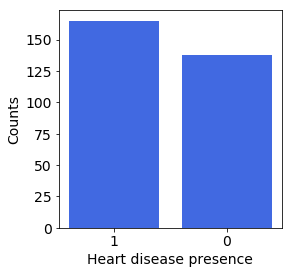

In [11]:
print(df['target'].value_counts())
print("\nHeart Disease %d = %0.2f %%"%(df['target'].value_counts().index[0], df['target'].value_counts()[1]/df.shape[0]*100))
print("Heart Disease %d = %0.2f %%"%(df['target'].value_counts().index[1], df['target'].value_counts()[0]/df.shape[0]*100))

label=['1','0']
height=df['target'].value_counts()

plt.figure(figsize=(4,4))
plt.rcParams.update({'font.size': 14})
plt.bar(label, height, color='royalblue', label='target=0')
plt.ylabel('Counts')
plt.xlabel('Heart disease presence')
plt.show()

Other binary features are also visualized.

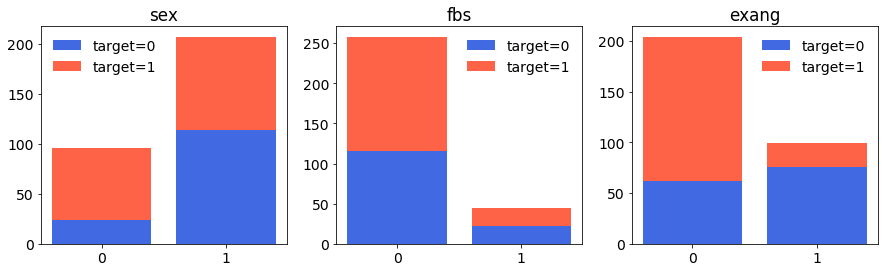

In [12]:
plt.figure(figsize=(15,4))

for i, col_label in enumerate(binary_col_label):
    plt.subplot('13%d'%(i+1))
    height1 = np.array([X[y==0][col_label].value_counts()[0], X[y==0][col_label].value_counts()[1]]) 
    height2 = np.array([X[y==1][col_label].value_counts()[0], X[y==1][col_label].value_counts()[1]]) 

    label=['0','1'] # sex, fbs, or exang
    plt.rcParams.update({'font.size': 14})
    plt.title(col_label)
    plt.bar(label, height1, color='royalblue', label='target=0')
    plt.bar(label, height2, bottom=height1, color='tomato', label='target=1')
    plt.legend(frameon = False)

Other categorical features are also summarized as bar charts.

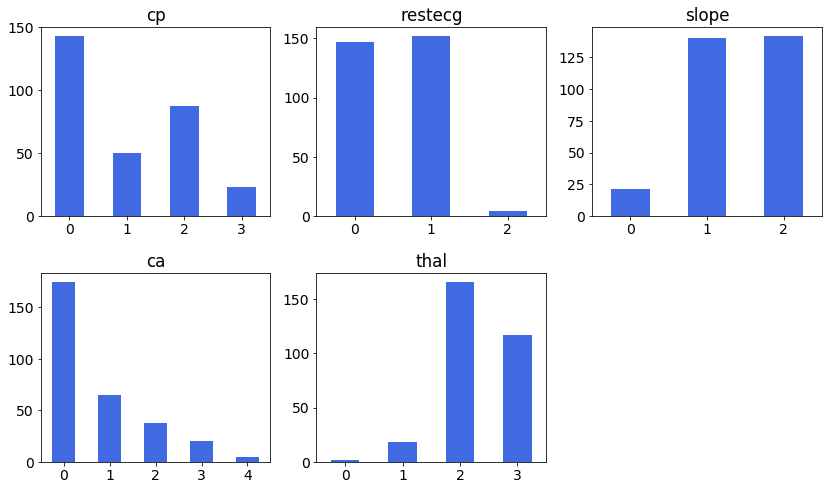

In [13]:
plt.figure(figsize=(14,8))
plt.rcParams.update({'font.size': 14})

for i, col_label in enumerate(categorical_col_label):
    plt.subplot(2,3,i+1)
    plt.title(col_label)
    X[col_label].value_counts(sort=False).plot.bar(rot=0, color='royalblue')
    
plt.subplots_adjust(wspace=0.2, hspace=0.3)

# Feature Engineering

## Feature Engineering 1: Correction of Skewness

Recall that there are 5 numerical features.

In [14]:
numerical_col_label

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

As we saw in the box plots and pairs plots, "trestbps" shows skewness. Most importantly, the distributions of this feature for the target 0 and 1 do not show a large difference. We can, therefore, modify the distribution in order to correct the skewness.

Pearson's second skewness coefficient (median skewness) is defined by 
$$
    \frac{3(\mu-m)}{\sigma},
$$
where &mu;, m, and &sigma; are the mean, median, and standard deviation, respectively. This parameter is calculated in the next cell.

In [15]:
trestbps=X[['trestbps']].values

skewness = 3*(np.mean(trestbps) - np.median(trestbps))/np.std(trestbps)

print("Skewness (trestbps):",skewness)

Skewness (trestbps): 0.27821335247289863


Since the skewness coefficient has a positive value, the distribution is called "positively-skewed distribution."

The observed skewness can be corrected by log transformation.

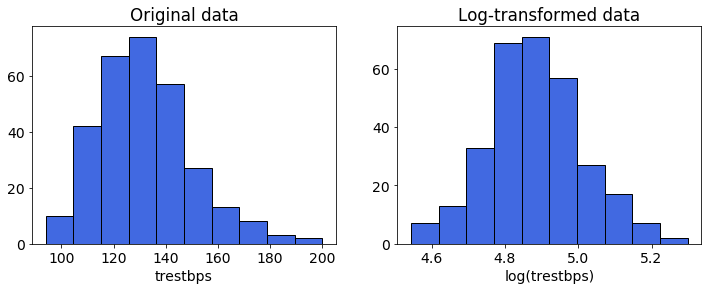

In [16]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("Original data")
plt.hist(trestbps, ec='black',color='royalblue')
plt.xlabel("trestbps")

plt.subplot(122)
plt.title("Log-transformed data")
plt.hist(np.log(trestbps), ec='black',color='royalblue')
plt.xlabel("log(trestbps)")
plt.show()

In [17]:
# log transformation
X[['trestbps']]=np.log(X[['trestbps']])

## Preparation of the training and test dataset.

The available data is split into training and test dataset.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, random_state=1, shuffle=True)

print("training data size: ",X_train.shape[0])
print("test data size: ", X_test.shape[0])

training data size:  242
test data size:  61


## Feature engineering 2: Target encoding and standardization

In the present analysis, [target encoding](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html) and [standardization](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) will be used for the categorical and numerical features, respectively.

### Test data

When performing the feature engineering for the test dataset, I got statistical information and target mean of the training dataset and then transformed the test dataset. 

<img src='fig/fig1.png' width=400, height=400>    

In the standardization, the mean and standard deviation are calculated using the training data. The numerical features of the test dataset are subtracted by the mean of the training dataset and divided by the standard deviation of the training dataset. 

In the target encoding process, the categorical variables are replaced by the mean of the target corresponding to them. Here, the mean of the target is calculated using the training data. The obtained mean of the target is used to replace the categorical variables of the test dataset.

In [19]:
# Target encoding
target_enc = ce.TargetEncoder(cols=binary_col_label + categorical_col_label, smoothing = 0)
target_enc.fit(X_train, y_train) # fit for the training dataset
X_test=target_enc.transform(X_test,y_test) # transform the test dataset

# Standardization
scaler = StandardScaler()
scaler.fit(X_train[numerical_col_label])  # fit for the training dataset
X_test[numerical_col_label]=scaler.transform(X_test[numerical_col_label]) # transform the test dataset

X_test.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
204,0.823571,0.783784,0.252252,1.582346,-1.602481,0.553398,0.469565,-0.192449,0.715152,4.723443,0.437500,0.200000,0.272727
159,0.166885,0.452381,0.837209,-0.015732,-0.493590,0.553398,0.469565,0.573130,0.715152,-0.933529,0.747826,0.751825,0.272727
219,-0.708697,0.452381,0.252252,-0.015732,0.187307,0.555556,0.469565,0.020212,0.207792,-0.933529,0.747826,0.206897,0.272727
174,0.604676,0.452381,0.252252,-0.015732,-0.785404,0.553398,0.469565,-0.745368,0.207792,1.256267,0.369369,0.206897,0.272727
184,-0.489801,0.452381,0.252252,1.085631,-0.065598,0.553398,0.469565,-0.915497,0.715152,1.438750,0.369369,0.751825,0.272727


### Training data

When performing the feature engineering to the training dataset, the data is split into K subsets. Using the statistical information obtained for the K-1 subsets, a validation dataset is transformed. In particular, the K-fold target encoding is important to avoid leakage. The sample figure shown below is the case where K=5

<img src='fig/fig2.png' width=900, height=900>    

In [20]:
# target encoding and standardization using K-fold
def Kfold_te_st(train_X, train_y, category_list, numerical_list, num_Kfold):

    X_ret = train_X.copy()
    X_ret1 = train_X[category_list].copy()    
    X_ret2 = train_X[numerical_list].copy()    
    kf = KFold(n_splits = num_Kfold, shuffle=False)

    for i, (tr_idx, va_idx) in enumerate(kf.split(train_X)):
        tr_X= train_X.iloc[tr_idx].copy()
        va_X = train_X.iloc[va_idx].copy()
        tr_y = train_y.iloc[tr_idx].copy()
        va_y =  train_y.iloc[va_idx].copy()

        # target encoding
        target_enc = ce.TargetEncoder(cols=category_list, smoothing = 0)
        target_enc.fit(tr_X[category_list], tr_y)
        X_ret1.iloc[va_idx] = target_enc.transform(va_X[category_list])
    
        # standardization
        scaler = StandardScaler()
        scaler.fit(tr_X[numerical_list])
        X_ret2.iloc[va_idx] = scaler.transform(va_X[numerical_list])
        
    X_ret[category_list] = X_ret1.copy()
    X_ret[numerical_list] = X_ret2.copy()
    
    return X_ret

In [21]:
num_folds=5 # K
df_temp=Kfold_te_st(X_train, y_train, binary_col_label + categorical_col_label, numerical_col_label , num_folds)
df_temp.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
62,-0.211203,0.466667,0.636364,-0.715007,-1.202201,0.551515,0.444444,1.698739,0.721805,-0.931850,0.325581,0.743363,0.125000
127,1.389409,0.741379,0.796610,1.178965,0.709630,0.551515,0.643564,0.922645,0.721805,-0.931850,0.742268,0.333333,0.765766
111,0.322334,0.466667,0.796610,1.079887,-2.462749,0.535714,0.643564,0.965761,0.721805,-0.742138,0.742268,0.333333,0.263889
287,0.322334,0.466667,0.906250,1.276748,-0.235781,0.551515,0.444444,0.577714,0.721805,-0.931850,0.742268,0.333333,0.765766
108,-0.424618,0.741379,0.906250,-0.589286,0.016328,0.551515,0.643564,0.491481,0.721805,0.111566,0.742268,0.743363,0.765766


# Model

## [LightGBM](https://lightgbm.readthedocs.io/en/latest/)

In the next cell, a function for performing cross validation is defined. Since the number of available data is limited, it is important to do the cross validation. During the cross validation process, the target encoding and standardization are implemented. As a model, [LightGBM](https://lightgbm.readthedocs.io/en/latest/) is chosen. This model is based on gradient boosting framework that uses tree-based models and performs very well for classification problems.  

In [22]:
def Kfold_CV_lgbm(train_X, train_y, test_X, test_y, model, category_list, numerical_list, num_Kfold, num_K_feature, feature_eng):

    kf = KFold(n_splits = num_Kfold, shuffle=False)

    preds_proba_test = []
    preds_proba_val = []
    preds_test = []
    test_score_list = []
        
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_X)):

        tr_X = train_X.iloc[tr_idx].copy()
        va_X = train_X.iloc[va_idx].copy()
        tr_y = train_y.iloc[tr_idx].copy()
        va_y = train_y.iloc[va_idx].copy()


        if feature_eng == True: # Feature engineering
            # Target encoding for the validation set using the training set
            target_enc = ce.TargetEncoder(cols=category_list, smoothing = 0)
            target_enc.fit(tr_X, tr_y)
            va_X = target_enc.transform(va_X, va_y)

            # Standardization for the validation set using the training set
            scaler = StandardScaler()
            scaler.fit(tr_X[numerical_list])
            va_X[numerical_list]=scaler.transform(va_X[numerical_list])

            # Target encoding and standardization for the training set
            tr_X = Kfold_te_st(tr_X, tr_y, category_list, numerical_list, num_K_feature)

        model.fit(tr_X, tr_y, eval_set=[(va_X, va_y)], early_stopping_rounds=10, verbose=-1)  
        
        pred_test = model.predict_proba(test_X)[:,1]
        preds_proba_test.append(pred_test)

        pred_val = model.predict_proba(va_X)[:,1]
        preds_proba_val.append(pred_val)
        
#        pred_test = model.predict(test_X)
#        preds_test.append(pred_test)
        
        test_score = model.score(test_X, test_y)
        test_score_list.append(test_score)
        
    # getting the average values    
    preds_test = np.mean(preds_test, axis=0)
    preds_proba_test = np.mean(preds_proba_test, axis=0)
    
    # prediction for the validation data
    preds_proba_val=np.concatenate(preds_proba_val)
    
    return  preds_proba_test, preds_proba_val, test_score_list

In [23]:
lgbm_params={
    'boosting_type': 'dart',  
    'objective': 'binary',
    'learning_rate': 0.001, 
    'num_boost_round': 12000, 
    'reg_lambda':0.1,  
    'num_leaves':2, 
    'max_bin':20 
}

modelLGBM=lgbm.LGBMClassifier(**lgbm_params)

### Without feature engineering

At first, let us define a function which returns 0 or 1 based on the given probability.

In [24]:
def classification_proba(proba): 
    return (proba >= 0.5).astype(np.int)

def score(y_test, proba):
    return(np.sum(y_test == classification_proba(proba).flatten())/y_test.shape[0])

As a reference, the model is trained with data which are not transformed using target encoding and standardization.

In [25]:
num_folds=5 # K for cross validation
num_K_feature = num_folds-1  # K for feature engineering
feature_eng=False # feature engineering

col_name = df.columns.tolist() # get column names
col_name.remove('target') # omit 'target'
X=df[col_name].copy() # create a feature matrix
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, random_state=1, shuffle=True)

preds_proba_test_lgbm, preds_proba_val_lgbm, test_score = Kfold_CV_lgbm(X_train, y_train, X_test, y_test, modelLGBM , binary_col_label + categorical_col_label, numerical_col_label , num_folds, num_K_feature, feature_eng)

print("\nTest score: %0.4f"%score(y_test, preds_proba_test_lgbm)) # 0.7705
print("Logloss for the test data: %0.4f"%log_loss(y_test, preds_proba_test_lgbm)) # 0.4477
print("F1 score: %0.4f"%f1_score(y_test, classification_proba(preds_proba_test_lgbm))) # 0.8000
#print("Confusion matrix:\n",confusion_matrix(y_test, classification_proba(preds_proba_test_lgbm)))


Test score: 0.7705
Logloss for the test data: 0.4477
F1 score: 0.8000


- Confusion matrix

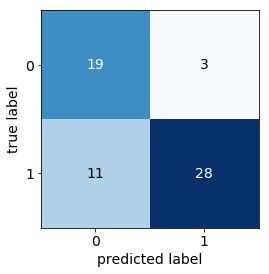

In [26]:
plot_confusion_matrix(conf_mat=confusion_matrix(y_test, classification_proba(preds_proba_test_lgbm)).T)
plt.show()

### Feature engineering

Next, the model is trained with transformed data. Other conditions are the same.

In [27]:
num_folds=5 # K for cross validation
num_K_feature = num_folds-1  # K for feature engineering
feature_eng=True # feature engineering

X[['trestbps']]=np.log(X[['trestbps']]) # correct skewness
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, random_state=1, shuffle=True)

# Target encoding
target_enc = ce.TargetEncoder(cols=binary_col_label + categorical_col_label, smoothing = 0)
target_enc.fit(X_train, y_train)
X_test=target_enc.transform(X_test,y_test)

# Standardization
scaler = StandardScaler()
scaler.fit(X_train[numerical_col_label])
X_test[numerical_col_label]=scaler.transform(X_test[numerical_col_label])


preds_proba_test_lgbm, preds_proba_val_lgbm, test_score = Kfold_CV_lgbm(X_train, y_train, X_test, y_test, modelLGBM , binary_col_label + categorical_col_label, numerical_col_label , num_folds, num_K_feature, feature_eng)

print("\nTest score: %0.4f"%score(y_test, preds_proba_test_lgbm)) # 0.8033
print("Logloss for the test data: %0.4f"%log_loss(y_test, preds_proba_test_lgbm)) # 0.4352
print("F1 score: %0.4f"%f1_score(y_test, classification_proba(preds_proba_test_lgbm))) # 0.8235
#print("Confusion matrix:\n",confusion_matrix(y_test, classification_proba(preds_proba_test_lgbm)))


Test score: 0.8033
Logloss for the test data: 0.4352
F1 score: 0.8235


As you can see, the accuracy, log loss, and F1 score are improved by performing the feature engineering.

- Confusion matrix

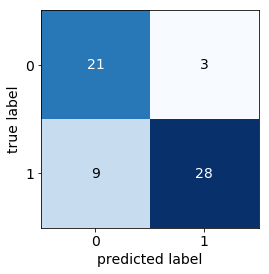

In [28]:
plot_confusion_matrix(conf_mat=confusion_matrix(y_test, classification_proba(preds_proba_test_lgbm)).T)
plt.show()

Target label (0 or 1) and predicted probability are shown for all patients to see their difference.

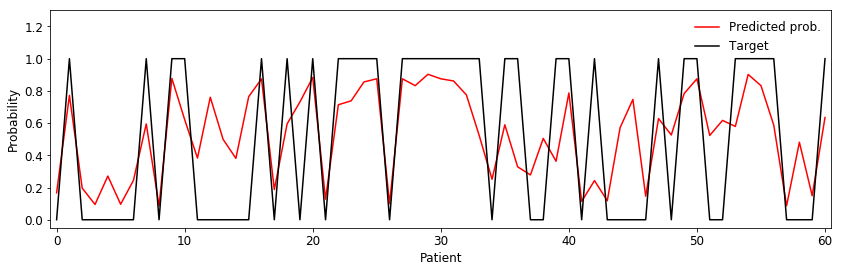

In [29]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0,y_test.shape[0]-1,y_test.shape[0]),preds_proba_test_lgbm, label='Predicted prob.', color='red')
plt.plot(np.linspace(0,y_test.shape[0]-1,y_test.shape[0]),y_test, label='Target', color='k')
plt.legend(frameon=False, loc=1)
plt.xlabel('Patient')
plt.ylabel('Probability')
plt.xlim([-0.5,60.5])
plt.ylim([-0.05,1.3])
plt.show()

## Neural network

Feedforward neural network which has 2 hidden layers with 16 nodes is built using [keras](https://keras.io). In the present case, the model is easily overfitted to the training data. In order to avoid the overffiting, [regularizers](https://keras.io/regularizers/) are used to apply penalties on layer parameters. The models with and without the regularizers are compared.

### Defining a function

In [30]:
def Kfold_CV_NN(train_X, train_y, test_X, test_y, model, category_list, numerical_list, num_Kfold, num_K_feature, feature_eng):

    kf = KFold(n_splits = num_Kfold, shuffle=False)

    preds_proba_test = []
    preds_test = []
    test_score_list = []
    preds_proba_val = []
    val_loss=0
    tr_loss=0

    for i, (tr_idx, va_idx) in enumerate(kf.split(train_X)):
        tr_X = train_X.iloc[tr_idx].copy()
        va_X = train_X.iloc[va_idx].copy()
        tr_y = train_y.iloc[tr_idx].copy()
        va_y = train_y.iloc[va_idx].copy()

        if feature_eng == True: # Feature engineering
            # Target encoding for the validation set using the training set
            target_enc = ce.TargetEncoder(cols=category_list, smoothing = 0)
            target_enc.fit(tr_X, tr_y)
            va_X = target_enc.transform(va_X, va_y)

            # Standardization for the validation set using the training set
            scaler = StandardScaler()
            scaler.fit(tr_X[numerical_list])
            va_X[numerical_list]=scaler.transform(va_X[numerical_list])

            # Target encoding and standardization for the training set
            tr_X = Kfold_te_st(tr_X, tr_y, category_list, numerical_list, num_K_feature)

#        early_stopping=callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)
        history=model.fit(tr_X, tr_y, epochs=500, batch_size=32,
                          validation_data=(va_X, va_y),
                          verbose=0)
 #                         callbacks=[early_stopping])  
        
        val_loss = val_loss + np.array(history.history['val_loss'])
        tr_loss = tr_loss + np.array(history.history['loss'])

        
        temp = model.predict_proba(test_X)
        preds_proba_test.append(temp)
        
        pred_val = model.predict_proba(va_X)
        preds_proba_val.append(pred_val)

        test_score = np.sum(test_y.values == model.predict_classes(test_X).flatten())/test_y.shape[0]
        test_score_list.append(test_score)
        
    # getting the average values    
#    preds_test = np.mean(preds_test, axis=0)
    preds_proba_test = np.mean(preds_proba_test, axis=0)
    val_loss=val_loss/num_Kfold
    tr_loss=tr_loss/num_Kfold

    # prediction for the validation data
    preds_proba_val=np.concatenate(preds_proba_val).flatten()
    
    return  preds_proba_test, preds_proba_val, test_score_list, val_loss, tr_loss

### Without regularization

In [31]:
n=X_train.shape[1]

import random
os.environ['PYTHONHASHSEED']=str(0)
random.seed(0)
np.random.seed(0)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

modelNN=models.Sequential()
modelNN.add(layers.Dense(16, activation=layers.LeakyReLU(alpha=0.27) ,
                         kernel_initializer='he_uniform',
#                         kernel_regularizer=regularizers.l2(0.05),
                         input_shape=(n,)))
modelNN.add(layers.Dropout(0.3))

modelNN.add(layers.Dense(16, activation=layers.LeakyReLU(alpha=0.27),
                         kernel_initializer='he_uniform'))
#                         kernel_regularizer=regularizers.l2(0.05)))
modelNN.add(layers.Dropout(0.3))

modelNN.add(layers.Dense(1,activation='sigmoid',kernel_initializer='he_uniform'))

modelNN.compile(optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

modelNN.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 513
Trainable params: 5

In [32]:
num_folds = 5 # K for cross validation
num_K_feature = num_folds-1 # K for feature engineering
feature_eng=True # feature engineering

preds_proba_test_nn, preds_proba_val_nn, test_score, val_loss, tr_loss = Kfold_CV_NN(X_train, y_train, X_test, y_test, modelNN , binary_col_label + categorical_col_label, numerical_col_label , num_folds, num_K_feature, feature_eng)

In [33]:
#print("test score:", test_score)
print("\nTest score: %0.4f"%score(y_test, preds_proba_test_nn)) # 0.7869
print("Logloss for the test data: %0.4f"%log_loss(y_test, preds_proba_test_nn)) # 0.5194
print("F1 score: %0.4f"%f1_score(y_test, classification_proba(preds_proba_test_nn))) # 0.8000
#print("Confusion matrix:\n",confusion_matrix(y_test, classification_proba(preds_proba_test_nn)))


Test score: 0.7869
Logloss for the test data: 0.5206
F1 score: 0.8000


- Confusion matrix

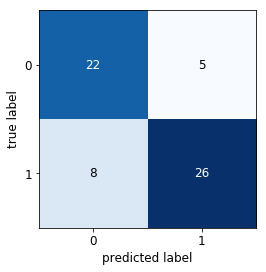

In [34]:
plot_confusion_matrix(conf_mat=confusion_matrix(y_test, classification_proba(preds_proba_test_nn)).T)
plt.show()

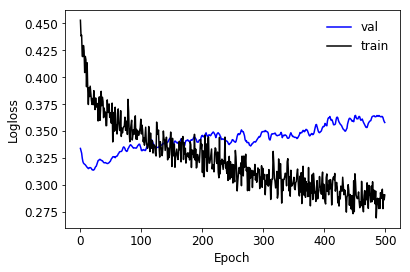

In [35]:
plt.plot(val_loss, label='val', color='blue')
plt.plot(tr_loss, label='train', color='black')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Logloss')
plt.show()

The learning curve for the validation data is obviously not good. The model is overfitted to the training dataset even though dropout layers are added to avoid overfitting.

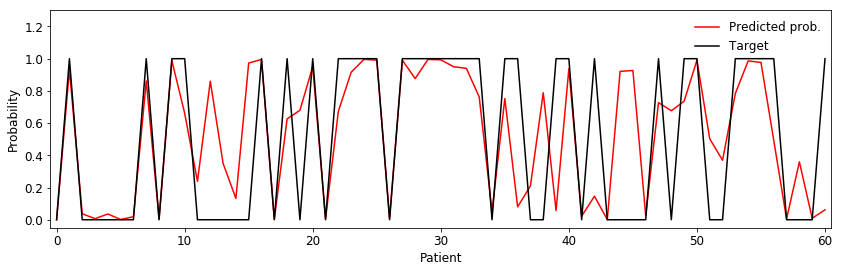

In [36]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0,y_test.shape[0]-1,y_test.shape[0]),preds_proba_test_nn, label='Predicted prob.', color='red')
plt.plot(np.linspace(0,y_test.shape[0]-1,y_test.shape[0]),y_test, label='Target', color='k')
plt.legend(frameon=False, loc=1)
plt.xlabel('Patient')
plt.ylabel('Probability')
plt.xlim([-0.5,60.5])
plt.ylim([-0.05,1.3])
plt.show()

### With regularization

A model defined here is basically the same as the previous one, except for kernel_regularizer.

In [42]:
n=X_train.shape[1]

import random
os.environ['PYTHONHASHSEED']=str(0)
random.seed(0)
np.random.seed(0)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

modelNN=models.Sequential()
modelNN.add(layers.Dense(16, activation=layers.LeakyReLU(alpha=0.2) ,
                         kernel_initializer='he_uniform',
                         kernel_regularizer=regularizers.l2(0.05),
                         input_shape=(n,)))
modelNN.add(layers.Dropout(0.3))

modelNN.add(layers.Dense(16, activation=layers.LeakyReLU(alpha=0.2),
                         kernel_initializer='he_uniform', 
                         kernel_regularizer=regularizers.l2(0.05)))
modelNN.add(layers.Dropout(0.3))

modelNN.add(layers.Dense(1,activation='sigmoid',kernel_initializer='he_uniform'))

modelNN.compile(optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

modelNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 16)                224       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [43]:
num_folds = 5 # K for cross validation
num_K_feature = num_folds-1 # K for feature engineering
feature_eng=True # feature engineering

preds_proba_test_nn, preds_proba_val_nn, test_score, val_loss, tr_loss = Kfold_CV_NN(X_train, y_train, X_test, y_test, modelNN , binary_col_label + categorical_col_label, numerical_col_label , num_folds, num_K_feature, feature_eng)

In [45]:
#print("test score:", test_score)
print("\nTest score: %0.4f"%score(y_test, preds_proba_test_nn)) # 0.7869
print("Logloss for the test data: %0.4f"%log_loss(y_test, preds_proba_test_nn)) # 0.4558
print("F1 score: %0.4f"%f1_score(y_test, classification_proba(preds_proba_test_nn))) # 0.8060
#print("Confusion matrix:\n",confusion_matrix(y_test, classification_proba(preds_proba_test_nn)))


Test score: 0.7869
Logloss for the test data: 0.4568
F1 score: 0.8060


- Confusion matrix

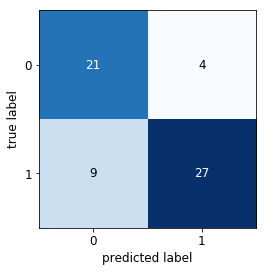

In [46]:
plot_confusion_matrix(conf_mat=confusion_matrix(y_test, classification_proba(preds_proba_test_nn)).T)
plt.show()

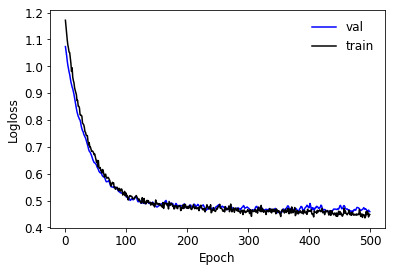

In [47]:
plt.plot(val_loss, label='val', color='blue')
plt.plot(tr_loss, label='train', color='black')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Logloss')
plt.show()

Activating the kernel_regularizer significantly improves the learning curve of the validation dataset. It looks healthy and does not show the effect of overfitting to the training dataset. 

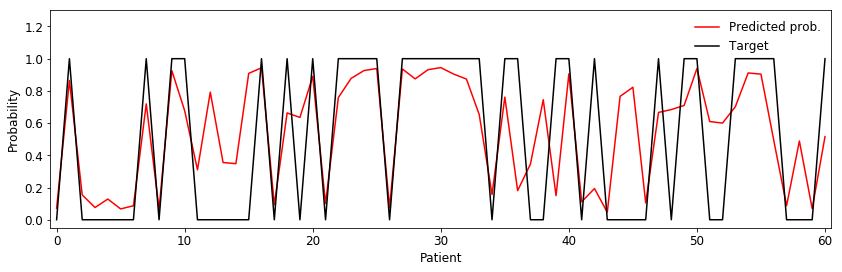

In [48]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0,y_test.shape[0]-1,y_test.shape[0]),preds_proba_test_nn, label='Predicted prob.', color='red')
plt.plot(np.linspace(0,y_test.shape[0]-1,y_test.shape[0]),y_test, label='Target', color='k')
plt.legend(frameon=False, loc=1)
plt.xlabel('Patient')
plt.ylabel('Probability')
plt.xlim([-0.5,60.5])
plt.ylim([-0.05,1.3])
plt.show()

## Random Forest

In [49]:
def Kfold_CV_rf(train_X, train_y, test_X, test_y, model, category_list, numerical_list, num_Kfold, num_K_feature, feature_eng):

    kf = KFold(n_splits = num_Kfold, shuffle=False)

    preds_proba_test = []
    preds_test = []
    test_score_list = []
    preds_proba_val = []
        
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_X)):

        tr_X = train_X.iloc[tr_idx].copy()
        va_X = train_X.iloc[va_idx].copy()
        tr_y = train_y.iloc[tr_idx].copy()
        va_y = train_y.iloc[va_idx].copy()
 
        if feature_eng == True: # Feature engineering
            # Target encoding for the validation set using the training set
            target_enc = ce.TargetEncoder(cols=category_list, smoothing = 0)
            target_enc.fit(tr_X, tr_y)
            va_X = target_enc.transform(va_X, va_y)

            # Standardization for the validation set using the training set
            scaler = StandardScaler()
            scaler.fit(tr_X[numerical_list])
            va_X[numerical_list]=scaler.transform(va_X[numerical_list])

            # Target encoding and standardization for the training set
            tr_X = Kfold_te_st(tr_X, tr_y, category_list, numerical_list, num_K_feature)

        model.fit(tr_X, tr_y)  
        
        pred_test = model.predict_proba(test_X)[:,1]
        preds_proba_test.append(pred_test)

        print("%d || Training / Validation || Score: %0.3f / %0.3f || Logloss: : %0.3f / %0.3f."%(i+1, model.score(tr_X,tr_y),model.score(va_X,va_y),log_loss(tr_y, model.predict_proba(tr_X)),log_loss(va_y, model.predict_proba(va_X))))

#        pred_test = model.predict(test_X)
#        preds_test.append(pred_test)

        pred_val = model.predict_proba(va_X)[:,1]
        preds_proba_val.append(pred_val)

        test_score = model.score(test_X, test_y)
        test_score_list.append(test_score)
        
    # getting the average values    
    preds_test = np.mean(preds_test, axis=0)
    preds_proba_test = np.mean(preds_proba_test, axis=0)

    # prediction for the validation data
    preds_proba_val=np.concatenate(preds_proba_val).flatten()

    return  preds_proba_test,preds_proba_val, test_score_list

In [50]:
rf_params={ 
    'n_estimators':5, #5
    'max_depth':2, #2
    'random_state':4 #4
}

modelRF = RandomForestClassifier(**rf_params)

num_folds=5 # K for cross validation
num_K_feature = num_folds-1 # K for feature engineering
feature_eng=True # feature engineering

preds_proba_test_rf, preds_proba_val_rf, test_score = Kfold_CV_rf(X_train, y_train, X_test, y_test, modelRF , binary_col_label + categorical_col_label, numerical_col_label , num_folds, num_K_feature, feature_eng)

#print("\nTest score", test_score)
print("\nTest score: %0.4f"%score(y_test, preds_proba_test_rf)) # 0.7869
print("Logloss for the test data: %0.4f"%log_loss(y_test, preds_proba_test_rf)) # 0.4583
print("F1 score: %0.4f"%f1_score(y_test, classification_proba(preds_proba_test_rf))) # 0.8060
#print("Confusion matrix:\n",confusion_matrix(y_test, classification_proba(preds_proba_test_rf)))

1 || Training / Validation || Score: 0.829 / 0.755 || Logloss: : 0.424 / 0.489.
2 || Training / Validation || Score: 0.845 / 0.776 || Logloss: : 0.411 / 0.527.
3 || Training / Validation || Score: 0.840 / 0.771 || Logloss: : 0.428 / 0.483.
4 || Training / Validation || Score: 0.799 / 0.875 || Logloss: : 0.455 / 0.440.
5 || Training / Validation || Score: 0.814 / 0.833 || Logloss: : 0.449 / 0.435.

Test score: 0.7869
Logloss for the test data: 0.4583
F1 score: 0.8060


- Confusion matrix

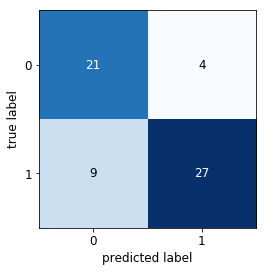

In [51]:
plot_confusion_matrix(conf_mat=confusion_matrix(y_test, classification_proba(preds_proba_test_rf)).T)
plt.show()

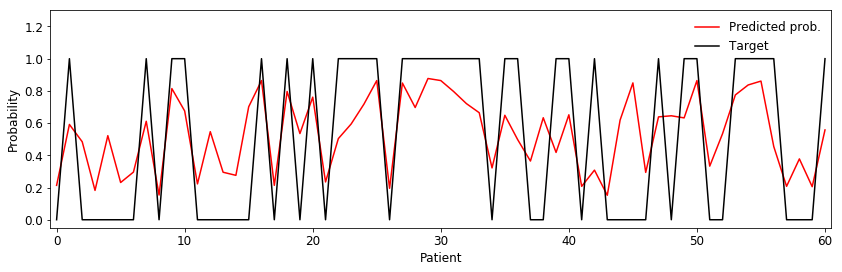

In [52]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0,y_test.shape[0]-1,y_test.shape[0]),preds_proba_test_rf, label='Predicted prob.', color='red')
plt.plot(np.linspace(0,y_test.shape[0]-1,y_test.shape[0]),y_test, label='Target', color='k')
plt.legend(frameon=False, loc=1)
plt.xlabel('Patient')
plt.ylabel('Probability')
plt.xlim([-0.5,60.5])
plt.ylim([-0.05,1.3])
plt.show()

## Logistic Regression

In [53]:
def Kfold_CV_LR(train_X, train_y, test_X, test_y, model, category_list, numerical_list, num_Kfold, num_K_feature, feature_eng):

    kf = KFold(n_splits = num_Kfold, shuffle=False)

    preds_proba_test = []
    preds_test = []
    test_score_list = []
    preds_proba_val = []
        
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_X)):

        tr_X = train_X.iloc[tr_idx].copy()
        va_X = train_X.iloc[va_idx].copy()
        tr_y = train_y.iloc[tr_idx].copy()
        va_y = train_y.iloc[va_idx].copy()
 
        if feature_eng == True: # Feature engineering
            # Target encoding for the validation set using the training set
            target_enc = ce.TargetEncoder(cols=category_list, smoothing = 0)
            target_enc.fit(tr_X, tr_y)
            va_X = target_enc.transform(va_X, va_y)

            # Standardization for the validation set using the training set
            scaler = StandardScaler()
            scaler.fit(tr_X[numerical_list])
            va_X[numerical_list]=scaler.transform(va_X[numerical_list])

            # Target encoding and standardization for the training set
            tr_X = Kfold_te_st(tr_X, tr_y, category_list, numerical_list, num_K_feature)

        model.fit(tr_X, tr_y)  
        
        pred_test = model.predict_proba(test_X)[:,1]
        preds_proba_test.append(pred_test)

        print("%d || Training / Validation || Score: %0.3f / %0.3f || Logloss: : %0.3f / %0.3f."%(i+1, model.score(tr_X,tr_y),model.score(va_X,va_y),log_loss(tr_y, model.predict_proba(tr_X)),log_loss(va_y, model.predict_proba(va_X))))

#        pred_test = model.predict(test_X)
#        preds_test.append(pred_test)

        pred_val = model.predict_proba(va_X)[:,1]
        preds_proba_val.append(pred_val)

        test_score = model.score(test_X, test_y)
        test_score_list.append(test_score)
        
    # getting the average values    
    preds_test = np.mean(preds_test, axis=0)
    preds_proba_test = np.mean(preds_proba_test, axis=0)

    # prediction for the validation data
    preds_proba_val=np.concatenate(preds_proba_val).flatten()

    return  preds_proba_test,preds_proba_val, test_score_list

In [54]:
lr_params={ 
    'C':6.9, # 6.9
    'random_state':0, # 0
    'penalty':'l2', # l2
    'solver':'lbfgs' #lbfgs
}

modelLR = LogisticRegression(**lr_params)

num_folds=5 # K for cross validation
num_K_feature = num_folds-1  # K for feature engineering
feature_eng=True # feature engineering

preds_proba_test_lr, preds_proba_val_lr, test_score = Kfold_CV_LR(X_train, y_train, X_test, y_test, modelLR , binary_col_label + categorical_col_label, numerical_col_label , num_folds, num_K_feature, feature_eng)

#print("\nTest score", test_score)
print("\nTest score: %0.4f"%score(y_test, preds_proba_test_lr)) # 0.7869
print("Logloss for the test data: %0.4f"%log_loss(y_test, preds_proba_test_lr)) # 0.4457
print("F1 score: %0.4f"%f1_score(y_test, classification_proba(preds_proba_test_lr))) # 0.8060

1 || Training / Validation || Score: 0.891 / 0.816 || Logloss: : 0.298 / 0.426.
2 || Training / Validation || Score: 0.886 / 0.796 || Logloss: : 0.298 / 0.495.
3 || Training / Validation || Score: 0.876 / 0.875 || Logloss: : 0.315 / 0.373.
4 || Training / Validation || Score: 0.845 / 0.938 || Logloss: : 0.352 / 0.245.
5 || Training / Validation || Score: 0.861 / 0.896 || Logloss: : 0.342 / 0.278.

Test score: 0.7869
Logloss for the test data: 0.4457
F1 score: 0.8060


- Confusion matrix 

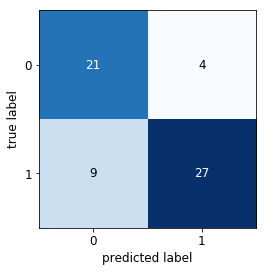

In [55]:
plot_confusion_matrix(conf_mat=confusion_matrix(y_test, classification_proba(preds_proba_test_lr)).T)
plt.show()

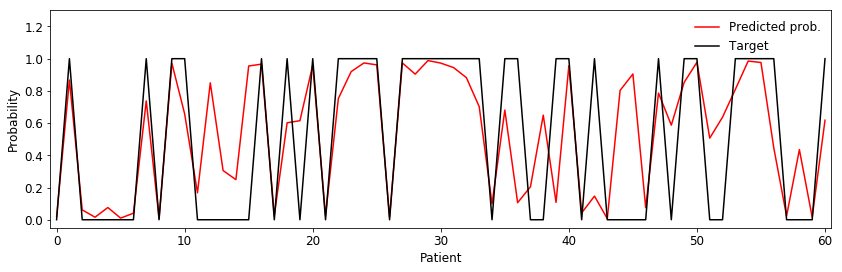

In [56]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0,y_test.shape[0]-1,y_test.shape[0]),preds_proba_test_lr, label='Predicted prob.', color='red')
plt.plot(np.linspace(0,y_test.shape[0]-1,y_test.shape[0]),y_test, label='Target', color='k')
plt.legend(frameon=False, loc=1)
plt.xlabel('Patient')
plt.ylabel('Probability')
plt.xlim([-0.5,60.5])
plt.ylim([-0.05,1.3])
plt.show()

# Model Summary

|  Model  |   Accuracy  |  Log loss  |  F1   |
| ---- | ---- | ---- | ---- |
|  LightGBM  |  0.8033  |  0.4352  |  0.8235  |
|  Feedforward Neural Network  |  0.7869  |  0.4558  | 0.8060  |
|  Random Forest  |  0.7869  |  0.4583  |  0.8060  |
|  Logistic Regression  |  0.7869  |  0.4457  |  0.8060  |

- In terms of accuracy, log loss, and F1 score, <strong>LightGBM</strong> performs the best.

It should be noted that these are not the best performances of the models. Each model can be improved further. Here, these models are adjusted so that a stacked model, which is presented in the next section, can achieve the best performance.

# Stacking

Stacking is one of the techniques of ensemble learning. In the present case, LightGBM, random forest, and logistic regression models are used.

## New training and test dataset

In [57]:
preds_proba_val_lgbm=preds_proba_val_lgbm.reshape(-1,1) # LightGBM
preds_proba_val_nn=preds_proba_val_nn.reshape(-1,1) # Neural network
preds_proba_val_rf=preds_proba_val_rf.reshape(-1,1) # random forest
preds_proba_val_lr=preds_proba_val_lr.reshape(-1,1) # logistic regression

preds_proba_test_lgbm=preds_proba_test_lgbm.reshape(-1,1) # LightGBM
preds_proba_test_nn=preds_proba_test_nn.reshape(-1,1) # Neural network
preds_proba_test_rf=preds_proba_test_rf.reshape(-1,1) # random forest
preds_proba_test_lr=preds_proba_test_lr.reshape(-1,1) # logistic regression

## Stacking

### Best combination (LGBM + RF + LR)

By combining the predictions, a new feature is created.

In [78]:
X_train_new = np.concatenate([preds_proba_val_lgbm, preds_proba_val_rf, preds_proba_val_lr],axis=1)
X_test_new = np.concatenate([preds_proba_test_lgbm, preds_proba_test_rf, preds_proba_test_lr],axis=1)

In [79]:
print("X_train_new shape:",X_train_new.shape)
print("X_test_new shape:",X_test_new.shape)

X_train_new shape: (242, 3)
X_test_new shape: (61, 3)


In [80]:
clf = LogisticRegression(random_state=1, #1
                         C=1.3, # C=1.3
                         solver='liblinear' # liblinear
                        )

clf.fit(X_train_new, y_train) 

pred=clf.predict_proba(X_test_new)[:,1]

print("Test score: %0.4f"%clf.score(X_test_new, y_test)) # 0.8197
print("Logloss for the test data: %0.4f"%log_loss(y_test, pred)) # 0.4336
print("F1 score: %0.4f"%f1_score(y_test, classification_proba(pred))) # 0.8358
#print("Confusion matrix:\n",confusion_matrix(y_test, classification_proba(pred)))

Test score: 0.8197
Logloss for the test data: 0.4336
F1 score: 0.8358


- Confusion matrix

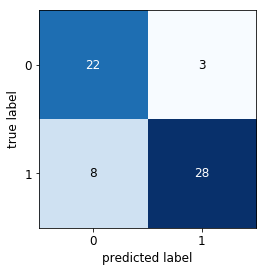

In [81]:
plot_confusion_matrix(conf_mat=confusion_matrix(y_test, classification_proba(pred)).T)
plt.show()

- Saving prediction

In [89]:
df_temp = pd.DataFrame(data=pred, index=y_test.index, columns=['probability']) # create a new data frame
df_temp.to_csv("pred.csv") # save to a csv file
df_temp.head()

,probability
204,0.089949
159,0.846187
219,0.126822
174,0.075247
184,0.155129


### Combination of all models (LGBM + FNN + RF + LR)

In [61]:
X_train_new = np.concatenate([preds_proba_val_lgbm, preds_proba_val_nn,  preds_proba_val_rf,  preds_proba_val_lr],axis=1)
X_test_new = np.concatenate([preds_proba_test_lgbm, preds_proba_test_nn, preds_proba_test_rf, preds_proba_test_lr],axis=1)


clf = LogisticRegression(random_state=1, #1
                         C=1.3, # C=1.3
                         solver='liblinear' # liblinear
                        )

clf.fit(X_train_new, y_train) 

pred=clf.predict_proba(X_test_new)[:,1]

print("Test score: %0.4f"%clf.score(X_test_new, y_test)) # 0.8197
print("Logloss for the test data: %0.4f"%log_loss(y_test, pred)) # 0.4336
print("F1 score: %0.4f"%f1_score(y_test, classification_proba(pred))) # 0.8358
#print("Confusion matrix:\n",confusion_matrix(y_test, classification_proba(pred)))

Test score: 0.7869
Logloss for the test data: 0.4438
F1 score: 0.8060


### LGBM + FNN + LR

In [62]:
X_train_new = np.concatenate([preds_proba_val_lgbm, preds_proba_val_nn,  preds_proba_val_lr],axis=1)
X_test_new = np.concatenate([preds_proba_test_lgbm, preds_proba_test_nn, preds_proba_test_lr],axis=1)


clf = LogisticRegression(random_state=1, #1
                         C=1.3, # C=1.3
                         solver='liblinear' # liblinear
                        )

clf.fit(X_train_new, y_train) 

pred=clf.predict_proba(X_test_new)[:,1]

print("Test score: %0.4f"%clf.score(X_test_new, y_test)) # 0.8197
print("Logloss for the test data: %0.4f"%log_loss(y_test, pred)) # 0.4336
print("F1 score: %0.4f"%f1_score(y_test, classification_proba(pred))) # 0.8358
#print("Confusion matrix:\n",confusion_matrix(y_test, classification_proba(pred)))

Test score: 0.7869
Logloss for the test data: 0.4486
F1 score: 0.8060


### LGBM + FNN + RF

In [70]:
X_train_new = np.concatenate([preds_proba_val_lgbm, preds_proba_val_nn,  preds_proba_val_rf],axis=1)
X_test_new = np.concatenate([preds_proba_test_lgbm, preds_proba_test_nn, preds_proba_test_rf],axis=1)


clf = LogisticRegression(random_state=1, #1
                         C=1.3, # C=1.3
                         solver='liblinear' # liblinear
                        )

clf.fit(X_train_new, y_train) 

pred=clf.predict_proba(X_test_new)[:,1]

print("Test score: %0.4f"%clf.score(X_test_new, y_test)) # 0.8197
print("Logloss for the test data: %0.4f"%log_loss(y_test, pred)) # 0.4336
print("F1 score: %0.4f"%f1_score(y_test, classification_proba(pred))) # 0.8358
#print("Confusion matrix:\n",confusion_matrix(y_test, classification_proba(pred)))

Test score: 0.8033
Logloss for the test data: 0.4376
F1 score: 0.8235


### FNN + RF + LR

In [71]:
X_train_new = np.concatenate([ preds_proba_val_nn,  preds_proba_val_rf,  preds_proba_val_lr],axis=1)
X_test_new = np.concatenate([ preds_proba_test_nn, preds_proba_test_rf, preds_proba_test_lr],axis=1)

clf = LogisticRegression(random_state=1, #1
                         C=1.3, # C=1.3
                         solver='liblinear' # liblinear
                        )

clf.fit(X_train_new, y_train) 

pred=clf.predict_proba(X_test_new)[:,1]

print("Test score: %0.4f"%clf.score(X_test_new, y_test)) # 0.8197
print("Logloss for the test data: %0.4f"%log_loss(y_test, pred)) # 0.4336
print("F1 score: %0.4f"%f1_score(y_test, classification_proba(pred))) # 0.8358
#print("Confusion matrix:\n",confusion_matrix(y_test, classification_proba(pred)))

Test score: 0.7869
Logloss for the test data: 0.4515
F1 score: 0.8060


# Summary

|  Model  |   Accuracy  |  Log loss  |  F1   |
| ---- | ---- | ---- | ---- |
|  LightGBM (LGBM) |  0.8033  |  0.4352  |  0.8235  |
|  <span style="color:gray">Feedforward Neural Network (FNN)</span>  |  <span style="color:gray">0.7869</span>  | <span style="color:gray">0.4558</span>  |  <span style="color:gray">0.8060</span>  |
|  Random Forest (RF)  |  0.7896  |  0.4583  |  0.8060  |
|  Logistic Regression (LR)  |  0.7869  |  0.4457  |  0.8060  |
|  Stacking (LGBM + FNN + RF + LR)|  0.7869  |  0.4438  |  0.8060  |
|  Stacking (LGBM + FNN + LR)|  0.7869  |  0.4486  |  0.8060  |
|  Stacking (LGBM + FNN + RF)|  0.8033  |  0.4376  |  0.8235  |
|  Stacking (FNN + RF + LR)|  0.7869  |  0.4515  |  0.8060  |
|  <span style="color:red">Stacking (LGBM + RF + LR)</span>   |  <span style="color:red">0.8197</span>   |  <span style="color:red">0.4336</span>  |  <span style="color:red">0.8358</span>  |

With the technique of stacking (LGBM + RF + LR), the best accuracy, log loss, and F1 score are achieved.